In [ ]:
# "Ai from scratch"
> "Ai algorithms from scratch"

- comments: true
- categories: [ai]
- publishes: true

In [ ]:
import scipy as sp 
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import sklearn 
from sklearn.linear_model import LinearRegression
import pymc3
from sklearn.metrics import r2_score, precision_score, recall_score, confusion_matrix

# Hypothesis testing

A particular brand of tires claims that its deluxe tire averages at least 50,000 miles before it needs to be replaced. From past studies of this tire, the standard deviation is known to be 8,000. A survey of owners of that tire design is conducted. From the 28 tires surveyed, the mean lifespan was 46,500 miles with a standard deviation of 9,800 miles. Using  𝛼=0.05 , is the data highly inconsistent with the claim?

In [ ]:
claim_pop_mean = 50_000
pop_std = 8000

n = 28
sample_mean = 46_500
sample_std = 9800

alpha = 0.05

In [ ]:
# 1. How far is the sample_mean from the pop_mean ?
# H0 => pop_mean = 50_000
# H1 => pop_mean > 50_000 or pop_mean < 50_000

print("If we know the pop std")
how_far_on_the_unit_normal_of_sample_means = (46_500 - 50_000) / (8000/np.sqrt(28) )
print(how_far_on_the_unit_normal_of_sample_means, " how_far_on_the_unit_normal_of_sample_means")
how_far_we_allow = - sp.stats.norm.ppf(0.95)
print(how_far_we_allow, " how_far_we_allow")
how_far_we_are_percent = sp.stats.norm.cdf(how_far_on_the_unit_normal_of_sample_means)
print(how_far_we_are_percent, " how_far_we_are_percent")
print("\n")
print("If we don't know the pop std")
how_far_on_the_unit_normal_of_sample_means = (46_500 - 50_000) / (9800/np.sqrt(28) )
print(how_far_on_the_unit_normal_of_sample_means, " how_far_on_the_unit_normal_of_sample_means")
how_far_we_allow = - sp.stats.t.ppf(0.95, df=28-1)
print(how_far_we_allow, " how_far_we_allow")
how_far_we_are_percent = sp.stats.t.cdf(how_far_on_the_unit_normal_of_sample_means, df=28-1)
print(how_far_we_are_percent, " how_far_we_are_percent")

If we know the pop std
-2.315032397181517  how_far_on_the_unit_normal_of_sample_means
-1.6448536269514722  how_far_we_allow
0.010305579572800304  how_far_we_are_percent


If we don't know the pop std
-1.8898223650461363  how_far_on_the_unit_normal_of_sample_means
-1.7032884457221265  how_far_we_allow
0.034781617022391444  how_far_we_are_percent


# Confidence interval 

In [ ]:
how_much_we_allow_on_unit_normal_distrib = sp.stats.norm.ppf(0.95)
how_much_we_allow_in_problem_domain = how_much_we_allow_on_unit_normal_distrib * (9800 / np.sqrt(n))
how_much_we_allow_in_problem_domain

3046.311548011343

In [ ]:
[46_500 - how_much_we_allow_in_problem_domain, 46_500 + how_much_we_allow_in_problem_domain]

[43453.68845198866, 49546.31154801134]

# Bayesian inference 

In [ ]:
fake_observed = sp.stats.norm(46, 9).rvs(size=28)
fake_observed.mean(), fake_observed.std()

(45.48803701443949, 8.076116332902322)

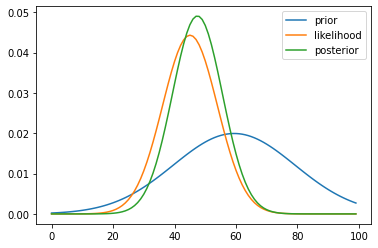

In [ ]:
# Doing it by hand with grid search approximation

from scipy.stats import norm, binom
import matplotlib.pyplot as plt


possible_probabilities_mean = np.linspace(0,100,100)

prior_mean = norm.pdf(possible_probabilities_mean, loc=60, scale=20)
prior_std = 9

plt.plot(prior_mean, label="prior")

likelihood_mean = norm.pdf(fake_observed.mean(), 
         loc=possible_probabilities_mean, 
         scale=9)

plt.plot(likelihood_mean, label="likelihood")

posterior_unnormalized = prior_mean * likelihood_mean
posterior = posterior_unnormalized / posterior_unnormalized.sum()

plt.plot(posterior, label="posterior")
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_prior, u_prior]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89f3d018d0>,
      dtype=object)

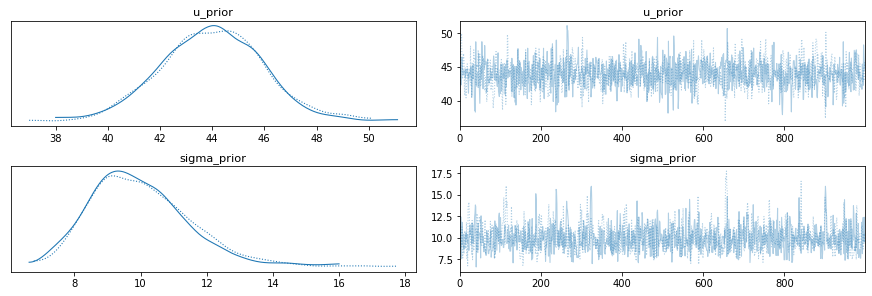

In [ ]:
# Doing it with pymc3
with pymc3.Model() as model: 
  u_prior = pymc3.distributions.Uniform("u_prior", 0, 100)
  sigma_prior = pymc3.distributions.Uniform("sigma_prior", 0, 20)
  likelihood = pymc3.distributions.Normal("likelihood", mu=u_prior, sigma=sigma_prior, observed=[fake_observed])
  trace = pymc3.sample()

pymc3.traceplot(trace)

# Linear Regression

In [ ]:
df = pd.read_csv("sample_data/california_housing_train.csv")
df = df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]
scaled_df = (df - df.min()) / (df.max() - df.min())
X = scaled_df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].values
y = scaled_df['median_house_value'].values

X_with_intercept = np.hstack((np.ones((len(X), 1)),X))
B = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ (X_with_intercept.T @ y.reshape(-1, 1))

lr = LinearRegression().fit(X, y)

print("Manual: ", B)
print("Manual score: ", r2_score(y, (X_with_intercept @ B).reshape(-1)))
print("")
print("Sklearn: ", lr.coef_, lr.intercept_)
print("Sklearn score: ", r2_score(y, lr.predict(X)))



Manual:  [[-0.07556544]
 [ 0.19769139]
 [-1.56087573]
 [ 1.32234017]
 [-2.57610401]
 [ 1.59516284]
 [ 1.43606576]]
Manual score:  0.5713482748283873

Sklearn:  [ 0.19769139 -1.56087573  1.32234017 -2.57610401  1.59516284  1.43606576] -0.07556543642855107
Sklearn score:  0.5713482748283873


# Logistic Regression

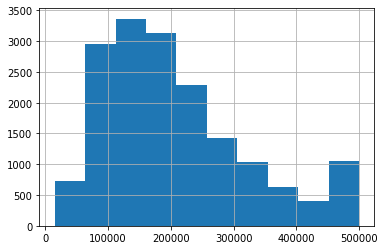

In [ ]:
df['median_house_value'].hist()

In [ ]:
def sigmoid(x):
  return  1 / (1 + np.exp(-x)) 

def log_likelihood(y_hat, y_true):
  return np.sum( y_true * np.log(y_hat) + (1-y_true) * np.log(1-y_hat) )

def gradients(X, y, y_hat):
    
    # X --> Input.
    # y --> true/target value.
    # y_hat --> hypothesis/predictions.
    # w --> weights (parameter).
    # b --> bias (parameter).
    
    # m-> number of training examples.
    m = X.shape[0]
    
    # Gradient of loss w.r.t weights.
    dw = (1/m)*np.dot(X.T, (y_hat - y))
    
    return dw

In [ ]:
df = pd.read_csv("sample_data/california_housing_train.csv")
df = df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]
df['median_house_value_cat'] = (df['median_house_value'] > 150_000).astype(int)
scaled_df = (df - df.min()) / (df.max() - df.min())
X = scaled_df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].values
y = df['median_house_value_cat'].values 
X_with_intercept = np.hstack((np.ones((len(X), 1)),X))

B = np.random.normal(0, 0.1 ,(7, 1))

for i in range(20_000):
  y_hat = sigmoid(X_with_intercept @ B).reshape(-1)
  if i % 1000 == 0 or i ==0: 
    print("loss: ", log_likelihood(y_hat, y))
  deltas = gradients(X_with_intercept, y, y_hat)
  B -= 0.3 * deltas.reshape(-1, 1)


lr = sklearn.linear_model.LogisticRegression().fit(X, y)

loss:  -11921.545904003113
loss:  -8967.128160745051
loss:  -8351.305989089486
loss:  -8083.278801524377
loss:  -7944.149245248092
loss:  -7863.547173838429
loss:  -7812.837065054392
loss:  -7778.616079912635
loss:  -7754.000783091298
loss:  -7735.216404729813
loss:  -7720.090594375023
loss:  -7707.32663707406
loss:  -7696.128260982457
loss:  -7685.995432558281
loss:  -7676.608432478169
loss:  -7667.759772286712
loss:  -7659.313087143786
loss:  -7651.177747927787
loss:  -7643.292887269918
loss:  -7635.617193645834


In [ ]:
print("Manual: ", B)
print("Manual score: ", 
        precision_score(y, (sigmoid(X_with_intercept @ B).reshape(-1) > 0.5).astype(int) ),
        recall_score(y, (sigmoid(X_with_intercept @ B).reshape(-1) > 0.5).astype(int) ),
      )
print()
print("Sklearn: ", lr.coef_, lr.intercept_)
print("Sklearn score", 
      precision_score(y, lr.predict(X)),
      recall_score(y, lr.predict(X))
      )

Manual:  [[-4.56223472]
 [ 2.12654314]
 [-3.80572231]
 [ 3.60375804]
 [-1.19804952]
 [ 4.550525  ]
 [17.74264368]]
Manual score:  0.8152614055610546 0.8442829186469109

Sklearn:  [[  1.96033532 -10.78106293   6.88219698  -2.86867989   7.2513503
   17.41000988]] [-4.38527394]
Sklearn score 0.8186773905272565 0.8536949026185817


# Confusion Matrix

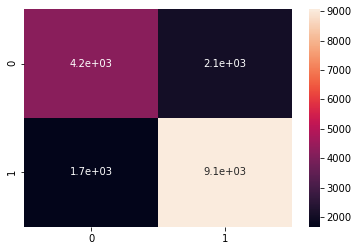

In [ ]:
sns.heatmap(confusion_matrix(y, (sigmoid(X_with_intercept @ B).reshape(-1) > 0.5).astype(int)), annot=True)

# Decision tree

In [ ]:
from sklearn.datasets import load_wine, load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [ ]:
load_breast_cancer()['feature_names'][22]

'worst perimeter'

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
f1_score(y, np.round(y.mean().repeat(len(y))))

0.7710583153347732

In [ ]:
X = pd.DataFrame(X)

smallest_gini_score = float("inf")
threshold_saved = None

# Pick a row and column to use as threshold
for col in X.columns: 
  for row in X.index:
    threshold = X.iloc[row, col]
    left_leaf_idx = X.loc[:, col] >= threshold
    right_leaf_idx = X.loc[:, col] < threshold
    if sum(left_leaf_idx) > 0 and sum(right_leaf_idx) > 0:

      # Compute the gini score with that threshold, and save it if it's the smallest so far
      gini_score_left = (1 - y[left_leaf_idx].mean()**2 - (1-y[left_leaf_idx].mean())**2) 
      gini_score_right = (1 - y[right_leaf_idx].mean()**2 - (1-y[right_leaf_idx].mean())**2) 
      gini_score = (sum(left_leaf_idx) * gini_score_left + sum(right_leaf_idx) * gini_score_right) / len(X)
      if gini_score < smallest_gini_score: 
        smallest_gini_score = gini_score
        threshold_saved = (col, row, threshold)

# We now use that threshold to split
print(threshold_saved)

(20, 31, 16.82)


In [ ]:
# Now predict using this split

left_leaf_idx = X.loc[:, 20] >= 16.82
right_leaf_idx = X.loc[:, 20] < 16.82

y_predict = pd.Series(y.copy())
y_predict[left_leaf_idx] = y[left_leaf_idx].mean()
y_predict[right_leaf_idx] = y[right_leaf_idx].mean()

print("Leaf sizes: ", len(left_leaf_idx), len(right_leaf_idx))
print("Leaf values: ", y[left_leaf_idx].mean(), y[right_leaf_idx].mean())
print("F1 score: ", f1_score(y, np.round(y_predict)))

Leaf sizes:  569 569
Leaf values:  0.05789473684210526 0.9129287598944591
F1 score:  0.9402173913043479


In [ ]:
# Compare with sklearn 
from sklearn import tree
t = DecisionTreeClassifier(max_depth=1, criterion='gini')
t.fit(X, y)
print(tree.export_text(t))

|--- feature_20 <= 16.80
|   |--- class: 1
|--- feature_20 >  16.80
|   |--- class: 0



# Random forest TODO

In [ ]:
from sklearn.datasets import load_wine, load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
for i in range(30):
  # 1. Use boosting to sample the data
  # 2. Pick a random subset of the features
  tree = DecisionTreeRegressor()
  tree.fit(X, y)

# Boosting trees

In [ ]:
from sklearn.datasets import load_wine, load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [ ]:
raw = load_breast_cancer(return_X_y=True)

X = pd.DataFrame(raw[0])
y = pd.DataFrame(raw[1])

In [ ]:
initial_prediction_proba = y.mean() 
initial_prediction_classes = round(initial_prediction_proba)
initial_prediction_logodds = np.log(initial_prediction_proba / (1-initial_prediction_proba))
proba_residuals = (y - initial_prediction_proba).values.reshape(-1)

print("Score with mean: ", f1_score(y, [1]*len(y)))

trees = []
for i in range(50): 
  tree = DecisionTreeRegressor(max_depth=1)
  tree.fit(X, proba_residuals)
  trees.append(tree)
  proba_residuals = proba_residuals - tree.predict(X).reshape(-1)

predictions = np.array(y.mean())
for tree in trees: 
  predictions = tree.predict(X).reshape(-1) + predictions
print("Final score: ", f1_score(y, predictions.round()))

Score with mean:  0.7710583153347732
Final score:  0.9902370990237099


# Gradient boosting tree

# Distributions TODO

## Normal distribution

## Poisson distribution 

In [ ]:
from scipy.stats import poisson 

# PCA


The principal components are the eigenvectors+eigenvalues of the Covariance matrix of our data. 

This is because we are looking for the "Direction of stretching and how much streching happens" regarding the variance of our data. 

In [ ]:
from sklearn.datasets import load_digits
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd 
import numpy as np

digits = pd.DataFrame(load_digits()['data'])
classes = load_digits(return_X_y=True)[1]

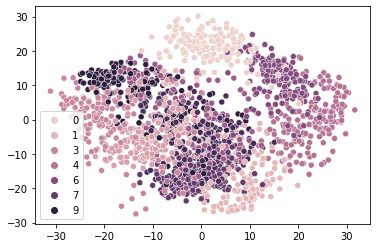

In [ ]:
low_dim_digits = PCA(n_components=2).fit_transform(digits)
sns.scatterplot(x=low_dim_digits[:,0], y=low_dim_digits[:,1], hue=classes)

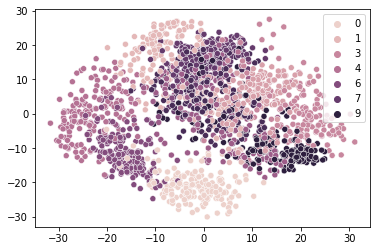

In [ ]:
digits_normed = digits - digits.mean()

# compute the covariance matrix 
cov_matrix = digits_normed.T  @ digits_normed / len(digits_normed) # digits_normed.cov()
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
eigen_values, eigen_vectors

# Sort eigen values end eigen vectors
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]

# Select the 2 best
eigenvector_subset = sorted_eigenvectors[:, 0:2]

X_reduced = np.dot(eigenvector_subset.transpose(), digits_normed.transpose()).transpose()
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=classes)



```
# Ce texte est au format code
```

# Matrix factorization

## SVD

In [ ]:
import pandas as pd
import numpy as np

raw = pd.read_csv("https://raw.githubusercontent.com/smanihwr/ml-latest-small/master/ratings.csv")
user_item_interactions = raw.pivot(values="rating", columns="movieId", index="userId")
user_item_interactions = user_item_interactions.fillna(0)

In [ ]:
from scipy.linalg import eig

In [ ]:
import numpy as np

A = np.array([
              [5,5,0,1],
              [5,5,0,0],
              [0,1,5,5],
              [0,0,5,5],
              [0,0,3,5]
])

# A = np.array([
#               [3, 2, 2],
#               [2, 3, -2],
# ])

U_eigen_values, U_unordered = np.linalg.eig(A @ A.T)
V_eigen_values, V_unordered = np.linalg.eig(A.T @ A)

idx_U = np.argsort(U_eigen_values)[::-1]
idx_V = np.argsort(V_eigen_values)[::-1]
D = np.sqrt(np.around(V_eigen_values[idx_V], decimals=10))
U = U_unordered[:,idx_U] # Using the order of U_eigen_values to reorder U
U = U * [[1,1,-1,-1,-1]] # Each eigenvector can be in 2 directions. Pick the correct one. Very manual. I actually based it on the result of np.linalg.svd. Not sure how you should actually be doing this.
V = (V_unordered[:,idx_V] * [[-1, -1, 1, -1]]) # Using the order of V_eigen_values to reorder V. # Each eigenvector can be in 2 directions. Pick the correct one. Very manual. 


In [ ]:
np.around(np.matrix(U) @ np.vstack((np.diag(D), np.zeros((len(V))))) @ np.matrix(V.T), decimals=1)

array([[ 5.,  5., -0.,  1.],
       [ 5.,  5.,  0., -0.],
       [ 0.,  1.,  5.,  5.],
       [-0.,  0.,  5.,  5.],
       [ 0., -0.,  3.,  5.]])

In [ ]:
U_, D_, Vt_ = np.linalg.svd(A)
np.around(np.matrix(U_) @ np.vstack((np.diag(D_), np.zeros((len(V_))))) @ np.matrix(Vt_), decimals=1)

array([[ 5.,  5.,  0.,  1.],
       [ 5.,  5., -0.,  0.],
       [-0.,  1.,  5.,  5.],
       [-0., -0.,  5.,  5.],
       [-0., -0.,  3.,  5.]])

## Truncated SVD

Truncate the SVD to 2 components by only keeping the two bigest eigenvalues

In [ ]:
np.matrix(U[:, :2])

matrix([[-0.23093819, -0.66810948],
        [-0.16863574, -0.68636674],
        [-0.59892473,  0.13274366],
        [-0.57986295,  0.20070102],
        [-0.47252267,  0.15693514]])

In [ ]:
np.around(np.matrix(U[:, :2]) @ np.diag(D[:2]) @ np.matrix(V[:,:2].T), decimals=1)

array([[ 5. ,  5. ,  0.3,  0.8],
       [ 5. ,  5. , -0.2,  0.2],
       [ 0.3,  0.7,  4.7,  5.3],
       [-0.2,  0.2,  4.7,  5.3],
       [-0.1,  0.2,  3.8,  4.3]])

## Using gradient descent TODO

In [ ]:
import numpy as np

A = np.array([
              [5,5,0,1],
              [5,5,0,0],
              [0,1,5,5],
              [0,0,5,5],
              [0,0,3,5]
])

U = np.random.rand(5, 3) * 0.01
D = np.random.rand(4, 3) * 0.01

In [ ]:
error = ((A - U @ D.T)**2).mean()
deltas =  A - U @ D.T


11.799389714228234

In [ ]:
https://medium.com/analytics-vidhya/matrix-factorization-made-easy-recommender-systems-7e4f50504477

# Neural network TODO

In [ ]:
import numpy as np

X = np.array([[1,0] , [0,0], [0,1], [1,1]])
y = np.array([[0,1] , [1,0], [0,1], [1,0]])

weights_input_hidden = np.random.rand(2, 4) * 0.001
weights_hidden_output = np.random.rand(4, 2) * 0.001

def relu(data):
  return np.maximum(data, 0)

def relu_grad(data): 
  return (data > 0 )* 1

def softmax(x):
  e_x = np.exp(x) - x.sum(axis=1).reshape(-1, 1)
  return e_x / e_x.sum(axis=1).reshape(-1, 1)

def softmax_grad(softmax):
  s = softmax.reshape(-1,1)
  return np.diagflat(s) - np.dot(s, s.T)


predictions = softmax(relu(X @ weights_input_hidden) @ weights_hidden_output)
errors = 

array([[0.50000012, 0.49999988],
       [0.5       , 0.5       ],
       [0.49999997, 0.50000003],
       [0.50000009, 0.49999991]])

In [ ]:
softmax_grad(predictions)

array([[ 0.25      , -0.25      , -0.24999999, -0.24999999, -0.24999996,
        -0.25000002, -0.24999994, -0.25000003],
       [-0.25      ,  0.25      , -0.25000001, -0.25000001, -0.24999998,
        -0.25000004, -0.24999997, -0.25000006],
       [-0.24999999, -0.25000001,  0.25      , -0.25      , -0.24999997,
        -0.25000003, -0.24999996, -0.25000004],
       [-0.24999999, -0.25000001, -0.25      ,  0.25      , -0.24999997,
        -0.25000003, -0.24999996, -0.25000004],
       [-0.24999996, -0.24999998, -0.24999997, -0.24999997,  0.25      ,
        -0.25      , -0.24999992, -0.25000001],
       [-0.25000002, -0.25000004, -0.25000003, -0.25000003, -0.25      ,
         0.25      , -0.24999999, -0.25000008],
       [-0.24999994, -0.24999997, -0.24999996, -0.24999996, -0.24999992,
        -0.24999999,  0.25      , -0.25      ],
       [-0.25000003, -0.25000006, -0.25000004, -0.25000004, -0.25000001,
        -0.25000008, -0.25      ,  0.25      ]])

# Loss functions TODO